In [2]:
# Task 2: PCA Dimension Reduction Setup
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


### DATA LOADING SECTION ###
print("\nDATA LOADING")
import zipfile
import os

# File paths
DATA_DIR = "data/"
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV = os.path.join(DATA_DIR, "test.csv")
TRAIN_TFIDF_ZIP = os.path.join(DATA_DIR, "train_tfidf_features.zip")
TEST_TFIDF_ZIP = os.path.join(DATA_DIR, "test_tfidf_features.zip")

def extract_zip_to_dataframe(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        
        csv_files = [f for f in zip_ref.namelist() if f.endswith('.csv')]
        if not csv_files:
            raise ValueError(f"No CSV file found in {zip_path}")
        
        csv_filename = csv_files[0]
        
        with zip_ref.open(csv_filename) as csv_file:
            df = pd.read_csv(csv_file)
    
    return df 

def load_all_data():
    
    train_df = pd.read_csv(TRAIN_CSV)
    test_df = pd.read_csv(TEST_CSV)
    
    # Load TD-IDF features from zip files
    X_train = extract_zip_to_dataframe(TRAIN_TFIDF_ZIP)
    X_test = extract_zip_to_dataframe(TEST_TFIDF_ZIP)
    
    # checking if 'label' in columns
    if 'label' in train_df.columns:
        y_train = train_df['label']
    elif 'target' in train_df.columns:
        y_train = train_df['target']
    else:
        return None, None, None, train_df, test_df
    
    return X_train, y_train, X_test, train_df, test_df


### DATA VALIDATION SECTION ###

def validate_data(X_train, y_train, X_test):
    
    print("\nDATA VALIDATION")
    
    # testing validation for number of features in zip file and mismatching btw train and test
    """if X_train.shape[1] == 5000:
        print("Correct number of features")
    else:
        print(f"Expected 5000 features, got {X_train.shape[1]}")
    
    if X_train.shape[1] == X_test.shape[1]:
        print("Train and test have same number of features")
    else:
        print(f"Feature mismatch - Train: {X_train.shape[1]}, Test: {X_test.shape[1]}")"""
    
    # Check for missing values
    if isinstance(X_train, pd.DataFrame):
        train_missing = X_train.isnull().sum().sum()
        test_missing = X_test.isnull().sum().sum()
    else:
        train_missing = np.isnan(X_train).sum()
        test_missing = np.isnan(X_test).sum()
    
    if train_missing > 0: 
        print(f"Missing values in training: {train_missing}")
    elif test_missing > 0: 
        print(f"Missing values in test: {test_missing}")
    
    return True

X_train, y_train, X_test, train_df, test_df = load_all_data()

# If successful, validate
if X_train is not None:
    validate_data(X_train, y_train, X_test)
    print("\nData loaded")
else:
    print("\nNeed to identify label column in train.csv")


### DATA DEBUGGING FUNCTION - for testing purposes :) ###

"""def debug_data_structure(X_train, X_test):
    
    print("=== DEBUGGING DATA STRUCTURE ===")
    print(f"X_train type: {type(X_train)}")
    print(f"X_test type: {type(X_test)}")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    
    if hasattr(X_train, 'columns'):
        print(f"X_train columns (first 10): {list(X_train.columns[:10])}")
        print(f"X_train columns (last 10): {list(X_train.columns[-10:])}")
        print(f"X_train dtypes: {X_train.dtypes.value_counts()}")
    
    if hasattr(X_test, 'columns'):
        print(f"X_test columns (first 10): {list(X_test.columns[:10])}")
        print(f"X_test columns (last 10): {list(X_test.columns[-10:])}")
        print(f"X_test dtypes: {X_test.dtypes.value_counts()}")
    
    print("END DEBUG\n")"""


### DATA PREPROCESSING ###

def preprocess_features(X_train, X_test):
    
    print("PREPROCESSING FEATURES")
    
    # remove 'id' and 'label' columns for training data
    train_feature_cols = [col for col in X_train.columns if col not in ['id', 'label']]
    X_train_clean = X_train[train_feature_cols]
    #print(f"Removed columns from train: {[col for col in X_train.columns if col not in train_feature_cols]}")
    
    # remove 'id' column for test data
    test_feature_cols = [col for col in X_test.columns if col not in ['id', 'label']]
    X_test_clean = X_test[test_feature_cols]
    #print(f"Removed columns from test: {[col for col in X_test.columns if col not in test_feature_cols]}")
    
    common_features = sorted(list(set(train_feature_cols) & set(test_feature_cols)))
    
    X_train_final = X_train_clean[common_features].values  
    X_test_final = X_test_clean[common_features].values    
    
    if X_train_final.shape[1] == X_test_final.shape[1]:
        print("Feature dimensions match")
    
    return X_train_final, X_test_final


### PCA IMPLEMENTATION ###

def apply_pca_multiple_components(X_train, X_test, component_list=[2000, 1000, 500, 100]):
    
    pca_results = {}
    
    print(f"\nAPPLYING PCA TO COMPONENTS: {component_list}")
    
    for n_components in component_list:
        
        # Initialize and fit PCA
        pca = PCA(n_components=n_components, random_state=42)
        pca.fit(X_train)
        
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        pca_results[n_components] = {
            'pca_model': pca,
            'X_train_pca': X_train_pca,
            'X_test_pca': X_test_pca,
            'explained_variance_ratio': pca.explained_variance_ratio_.sum()
        }
        
        print(f"PCA with {n_components} components COMPLETE")
        #print(f"  - Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
        #print(f"  - Train PCA shape: {X_train_pca.shape}")
        #print(f"  - Test PCA shape: {X_test_pca.shape}")
    
    return pca_results

### KNN TRAINING AND PREDICTION ###

def train_knn_and_predict(pca_results, y_train, component_list=[2000, 1000, 500, 100]):

    predictions = {}
    
    print(f"\nTRAINING KNN Models (n_neighbors=2)")
    
    for n_components in component_list:
        if n_components not in pca_results:
            continue
        
        X_train_pca = pca_results[n_components]['X_train_pca']
        X_test_pca = pca_results[n_components]['X_test_pca']
        
        knn = KNeighborsClassifier(n_neighbors=2)
        
        # Train the model
        knn.fit(X_train_pca, y_train)
        
        y_pred = knn.predict(X_test_pca)
        
        predictions[n_components] = {
            'model': knn,
            'predictions': y_pred,
            'n_predictions': len(y_pred)
        }
        
        print(f"KNN training COMPLETE for {n_components} components")
        #print(f"  - Predictions shape: {y_pred.shape}")
        #print(f"  - Prediction distribution: {np.bincount(y_pred)}")
    
    return predictions

### KAGGLE SUBMISSION PREPARATION ###

def prepare_kaggle_submissions(predictions, test_df, component_list=[2000, 1000, 500, 100]):

    submission_files = {}
    
    print(f"\nPREPARING KAGGLE SUBMISSION FILES")
    
    for n_components in component_list:
        if n_components not in predictions:
            continue
            
        y_pred = predictions[n_components]['predictions']
        
        # Create submission DataFrame
        # Assuming test_df has an 'id' column
        if 'id' in test_df.columns:
            submission_df = pd.DataFrame({
                'id': test_df['id'],
                'label': y_pred
            })
        else:
            # If no ID column, create sequential IDs
            submission_df = pd.DataFrame({
                'id': range(len(y_pred)),
                'label': y_pred
            })
        
        filename = f"submission_pca_{n_components}_components.csv"
        submission_df.to_csv(filename, index=False)
        
        submission_files[n_components] = filename
        
        print(f"Created {filename}")
        #print(f"  - Shape: {submission_df.shape}")
        #print(f"  - Sample:")
        #print(submission_df.head())
    
    return submission_files


### MAIN EXECUTION FUNCTION ###

def run_complete_pca_analysis(X_train, y_train, X_test, test_df):
    
    X_train_clean, X_test_clean = preprocess_features(X_train, X_test)
    
    pca_results = apply_pca_multiple_components(X_train_clean, X_test_clean)
    
    predictions = train_knn_and_predict(pca_results, y_train)
    
    submission_files = prepare_kaggle_submissions(predictions, test_df)
    
    print(f"\nAnalysis Complete!")
    
    return pca_results, predictions, submission_files


# Run the complete PCA analysis
pca_results, predictions, submission_files = run_complete_pca_analysis(X_train, y_train, X_test, test_df)


DATA LOADING

DATA VALIDATION

Data loaded
PREPROCESSING FEATURES
Feature dimensions match

APPLYING PCA TO COMPONENTS: [2000, 1000, 500, 100]
PCA with 2000 components COMPLETE
PCA with 1000 components COMPLETE
PCA with 500 components COMPLETE
PCA with 100 components COMPLETE

TRAINING KNN Models (n_neighbors=2)
KNN training COMPLETE for 2000 components
KNN training COMPLETE for 1000 components
KNN training COMPLETE for 500 components
KNN training COMPLETE for 100 components

PREPARING KAGGLE SUBMISSION FILES
Created submission_pca_2000_components.csv
Created submission_pca_1000_components.csv
Created submission_pca_500_components.csv
Created submission_pca_100_components.csv

Analysis Complete!


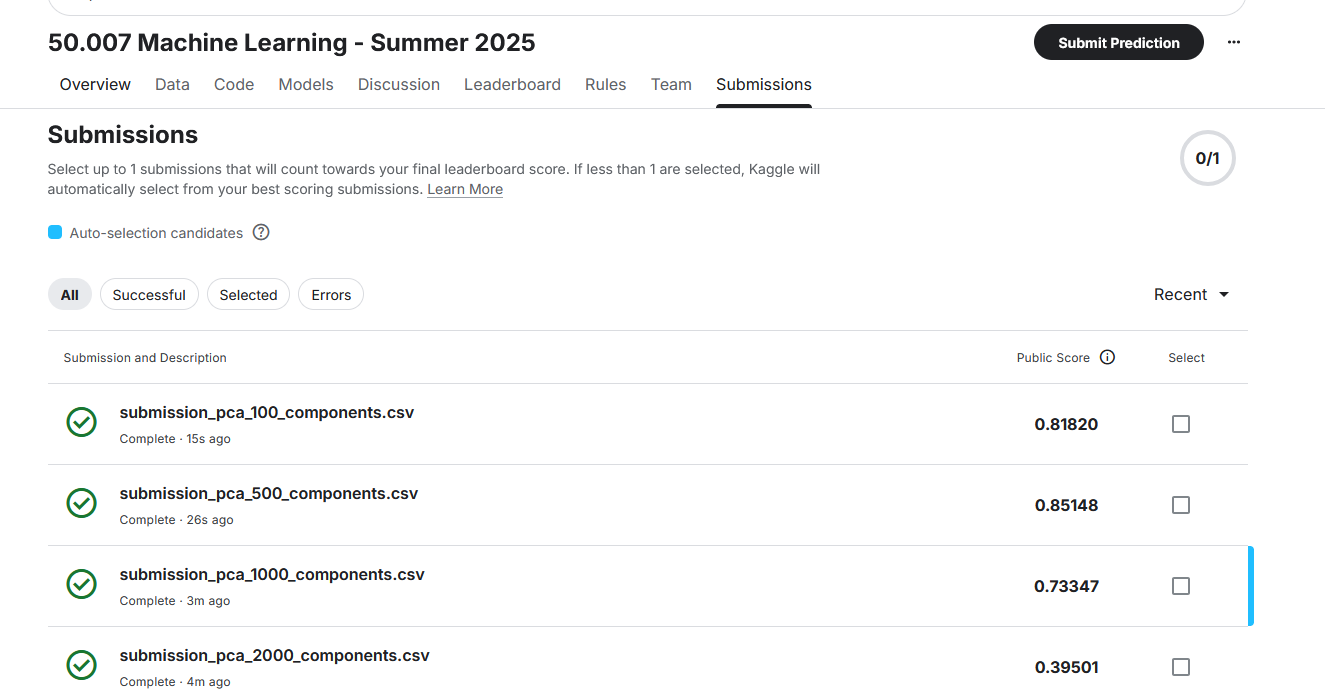